# CovID new cases predictions for the week 15/01/22 - 21/01/22 

Kyriaki Bimpiri 4725

In [1]:
# import the necessary libraries
import io, requests

import pandas as pd

import numpy as np


import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from scipy.optimize import curve_fit

In [2]:
def Load_precleaning():
    
    url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
    s = requests.get(url).content
    data = pd.read_csv(io.StringIO(s.decode('utf-8')))
    print('---------Load Complete---------'+'\n')
    data=data[data["location"] == 'Greece']
    return data
Df_raw=Load_precleaning()



---------Load Complete---------



In [3]:
def Col_date_selection(data,init_date):
    
    t0= int(np.where(data['date']==init_date)[0][0])
    data=data[t0:]
    
    print('Date of the second wave beggining: ',data['date'].iloc[0])
    print('Data end Date: ',data['date'].iloc[data.shape[0]-1])
    

    cols_for_use=['date','total_cases','new_cases','new_cases_smoothed',
                  'new_tests_smoothed','positive_rate','reproduction_rate']

    
    dfCov=data[cols_for_use]
    
    
    dfCov.insert(0,"ID",np.arange(0,dfCov.shape[0]).tolist())
    dfCov=dfCov.reset_index(drop=True)
    return dfCov
Data_Tot=Col_date_selection(data=Df_raw,init_date='2021-01-01')


Date of the second wave beggining:  2021-01-01
Data end Date:  2022-01-09


In [4]:
#Data_Tot.tail(5) <--- existing Nan Values in last 3 columns but
# Dropna not needed in this analysis because we deal with the new cases and new cases smoothed 
Data_Tot

,ID,date,total_cases,new_cases,new_cases_smoothed,new_tests_smoothed,positive_rate,reproduction_rate
0,0,2021-01-01,139447.0,597.0,656.429,20974.0,0.0313,0.86
1,1,2021-01-02,139709.0,262.0,656.429,20827.0,0.0315,0.86
2,2,2021-01-03,140099.0,390.0,663.286,21164.0,0.0313,0.88
3,3,2021-01-04,140526.0,427.0,656.429,21299.0,0.0308,0.89
4,4,2021-01-05,141453.0,927.0,639.571,21308.0,0.0300,0.90
...,...,...,...,...,...,...,...,...
369,369,2022-01-05,1388309.0,43386.0,36228.000,394619.0,0.0918,NaN
370,370,2022-01-06,1422020.0,33711.0,35961.000,393982.0,0.0913,NaN
371,371,2022-01-07,1451354.0,29334.0,34357.286,NaN,NaN,NaN
372,372,2022-01-08,1489024.0,37670.0,35451.714,NaN,NaN,NaN


array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

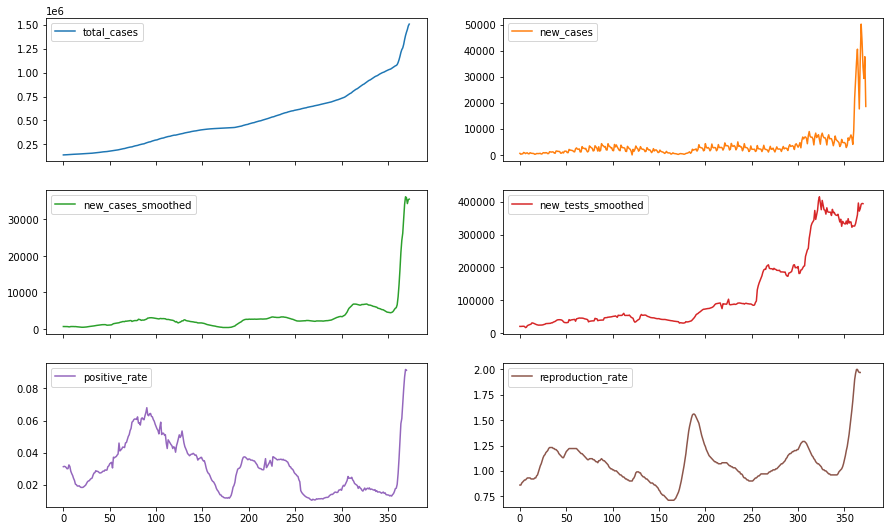

In [5]:
Data_Tot.iloc[:,1:].plot(use_index=True,subplots=True, layout=(3,2),figsize=(15,9))

<IPython.core.display.Javascript object>


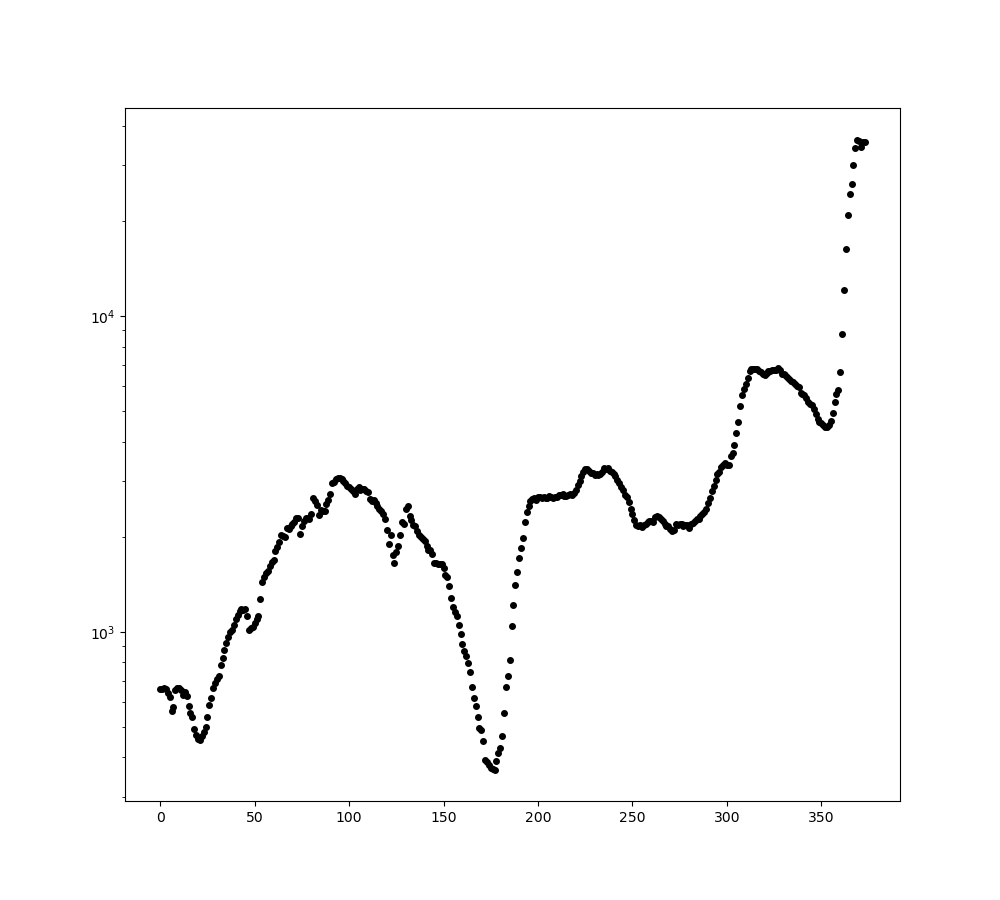

In [6]:
%matplotlib notebook

plt.figure(1,figsize=(10,9))
plt.semilogy(Data_Tot["ID"],Data_Tot["new_cases_smoothed"],'k.',ms=8)

plt.show()



# %matplotlib notebook "activates" the graph in order to see the coordinates with the cursor
# we use semilogy plot in order to be able to locate better the local minima of the peaks we are interested in.

$\large \underline{Step\;1} $: Taking the advantage of the previous $''\textit{new cases smoothed}''$ peaks, we can predict the day in which the next minimum will appear.

1) We find the most pronounced local minima (red x in the left panel of figure 2)


2) We plot the "distance" (in days) of these minima


3) We are searching a reasonable relation between these minima and predict the day that the next minimum will appear.


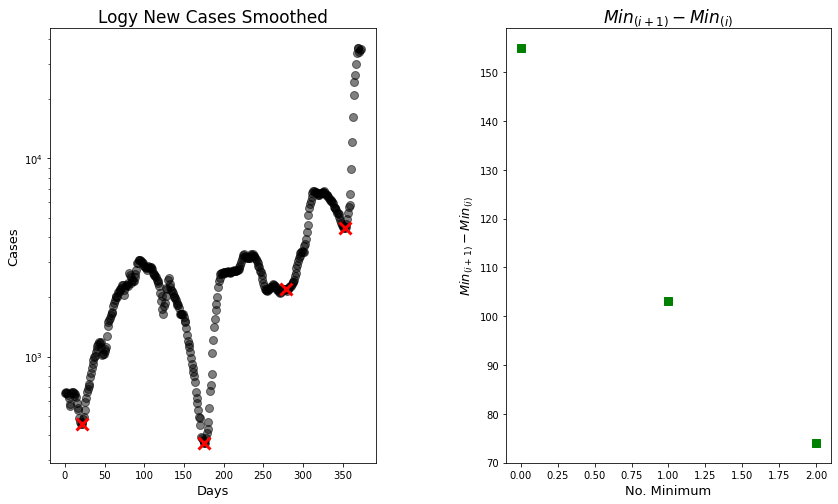

In [7]:
args_x_min=[21,176,279,353] #local_minima
Dmin=Data_Tot.iloc[args_x_min][['ID','new_cases_smoothed']]

%matplotlib inline
plt.figure(2,figsize=(14,8))
plt.subplot(121)
plt.title("Logy New Cases Smoothed",fontsize=17)
plt.semilogy(Data_Tot["ID"],Data_Tot["new_cases_smoothed"],'ko',ms=8,alpha=0.5)
plt.semilogy(Dmin['ID'],Dmin['new_cases_smoothed'],'rx',ms=12,mew=3)
plt.xlabel("Days",fontsize=13)
plt.ylabel("Cases",fontsize=13)

plt.subplot(122)
plt.title(r"$Min_{(i+1)}-Min_{(i)}$",fontsize=17)
plt.plot(np.diff(Dmin['ID']),'gs',ms=8)
plt.xlabel('No. Minimum',fontsize=13)
plt.ylabel(r"$Min_{(i+1)}-Min_{(i)}$",fontsize=13)

plt.subplots_adjust(wspace=0.4)



In [8]:
def polynomial_fit(x,y,x_plot,order=2):

    #min_dist=np.log(np.diff(Dmin['ID']))
    poly_regs= PolynomialFeatures(degree= int(order))
    
    x_poly= poly_regs.fit_transform(x.reshape(-1,1))  
    lin_reg_2 =LinearRegression()  
    lin_reg_2.fit(x_poly, y)
    y_plot=lin_reg_2.predict(poly_regs.fit_transform(x_plot.reshape(-1,1)))
    return {'x_plot':x_plot,"y_plot":y_plot}

In [9]:
poly1=polynomial_fit(x=np.arange(0,len(Dmin['ID'])-1),y=np.diff(Dmin['ID']),x_plot=np.linspace(0,len(Dmin['ID'])))
poly2=polynomial_fit(x=np.arange(0,len(Dmin['ID'])-1),y=np.log(np.diff(Dmin['ID'])),x_plot=np.linspace(0,len(Dmin['ID'])))
poly3=polynomial_fit(x=np.arange(0,len(Dmin['ID'])-1),y=np.diff(Dmin['ID']),x_plot=np.linspace(0,len(Dmin['ID'])),order=1)

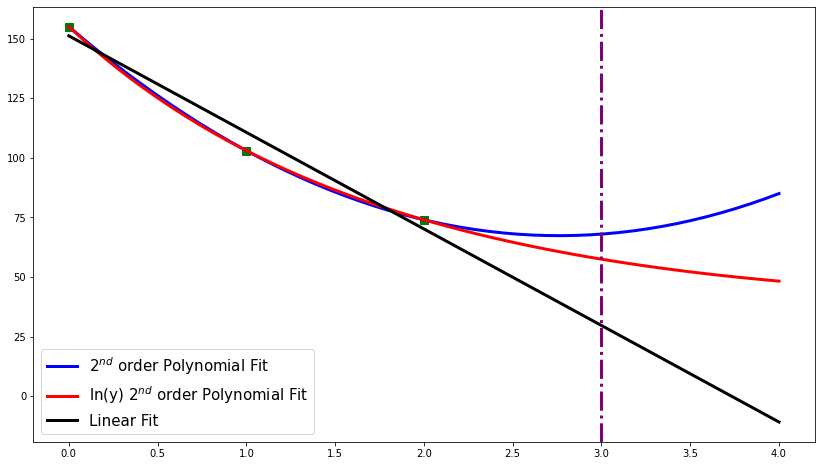

In [10]:
plt.figure(3,figsize=(14,8))
plt.plot(np.diff(Dmin['ID']),'gs',ms=8)
plt.plot(poly1['x_plot'],poly1['y_plot'],'b-',lw=3,label=r"$2^{nd}$ order Polynomial Fit")
plt.plot(poly2['x_plot'],np.exp(poly2['y_plot']),'r-',lw=3,label=r"ln(y) $2^{nd}$ order Polynomial Fit")
plt.plot(poly3['x_plot'],poly3['y_plot'],'k-',lw=3,label="Linear Fit")
plt.legend(fontsize=15)
plt.axvline(3,color='purple',ls="-.",lw=3)

Between these 3 fitting options, the most reasonable one seems to be the polynomial fit on the ln(y) (red line).

The reason is that, performing a 2nd order polynomial fit on the y data (blue line), the declining behaviour of the distance between the local minima is not satisfied.

On the other hand, the linear fit on the data, follows the desired trend in an excessive way, so it is rejected as an option, as well.

The 2nd order polynomial fit on the ln(y) data points, is somewhere in between of these two behaviours.

In [11]:
pred=polynomial_fit(x=np.arange(0,len(Dmin['ID'])-1),y=np.log(np.diff(Dmin['ID'])),x_plot=np.array([3]))['y_plot']

day_next_min=int(np.exp(np.round(pred,0)))
del pred

print("Next min will appear after {:3.1f} days from the last minimum".format(day_next_min))


Next min will appear after 54.0 days from the last minimum


Now we can use once again these data points in order to predict the cases in that day.

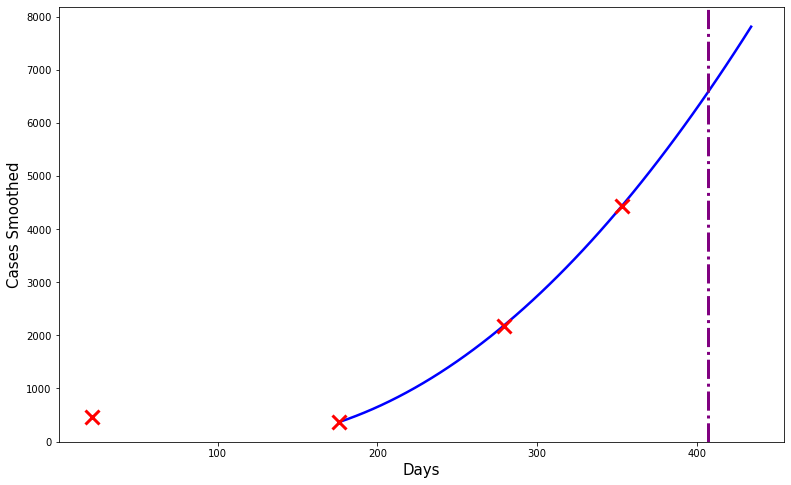

In [12]:
plt.figure(4,figsize=(13,8),clear=True)
plt.plot(Dmin['ID'],Dmin['new_cases_smoothed'],'rx',ms=14,mew=3,zorder=3)


poly_d=polynomial_fit(x=Dmin['ID'][1:].to_numpy(),y=Dmin['new_cases_smoothed'][1:].to_numpy(),
                      x_plot=np.linspace(Dmin['ID'][1:].min(),Dmin['ID'].max()+1.5*day_next_min))

plt.plot(poly_d['x_plot'],poly_d['y_plot'],'b-',lw=2.5)
plt.xlabel("Days",fontsize=15)
plt.ylabel("Cases Smoothed",fontsize=15)
plt.axvline(Dmin['ID'].max()+day_next_min,color='purple',ls="-.",lw=3)

In [13]:
pred=polynomial_fit(x=Dmin['ID'][1:].to_numpy(),y=Dmin['new_cases_smoothed'][1:].to_numpy(),
                    x_plot=np.array([Dmin['ID'].max()+day_next_min]))['y_plot']

cases_next_min=np.round(pred,0)[0]
del pred

print("Next min will appear after {0:3.0f} days from the last minimum with {1:5.0f} cases".format(day_next_min,cases_next_min))


Next min will appear after  54 days from the last minimum with  6583 cases


Now, it is our final step where we perform our final fit in order to predict the behaviour of the new cases.

The first problem we are facing is that the current trend is intensively on the increase. Therefore it is quite easy for our prediction to be extremely high because we are going to fit an exponential Gaussian-like curve. 

In order to avoid such behaviour we have to somehow bound the fitting procedure. The analysis above gave us one more point in our plot, at the predicted end of the cases-peak we are right now.


Text(0, 0.5, 'Cases')

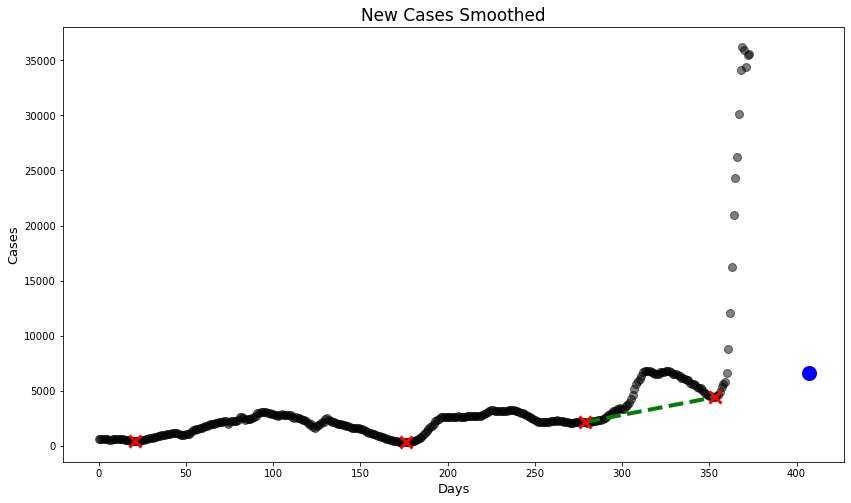

In [14]:
plt.figure(5,figsize=(14,8))
plt.title("New Cases Smoothed",fontsize=17)
plt.plot(Data_Tot["ID"],Data_Tot["new_cases_smoothed"],'ko',ms=8,alpha=0.5)
plt.plot(Dmin.iloc[[2,3]]['ID'],Dmin.iloc[[2,3]]['new_cases_smoothed'],'g--',lw=4)
plt.plot(Dmin['ID'],Dmin['new_cases_smoothed'],'rx',ms=12,mew=3)
plt.plot(Dmin['ID'].max()+day_next_min,cases_next_min,'bo',ms=12,mew=3)
plt.xlabel("Days",fontsize=13)
plt.ylabel("Cases",fontsize=13)

As we observe from the graph, the whole cases distribution is built on a background. Assuming that under each peak, the background is linear (example: green dashed line), the subtraction of this background from a peak will result in the peak itself without any offset. 

1)  Following this thought, we subtract a linear background from the data-points after the last minimum recorded.


2) The second assumption we are going to do, without interfering too much on the data, is to assume that the peak we are investigating behaves in the same way at its end. The reason we are doing this is because we have >10 points at the starting peak-region and only 1 point at the end. One point, of course, is not enough to mark a downward trajectory.

In [34]:
dnew=Data_Tot.iloc[Dmin['ID'].max():][['ID','new_cases_smoothed','new_cases']].copy()
dnew.loc[len(dnew.index)] = [Dmin['ID'].max()+day_next_min,cases_next_min,cases_next_min] 
dnew=dnew.reset_index(drop=True)

def line(d12,bg_col='new_cases_smoothed'):
    
    slope=(d12.iloc[-1][bg_col]-d12.iloc[0][bg_col])/(d12.iloc[-1]['ID']-d12.iloc[0]['ID'])
    
    interc=d12.iloc[0][bg_col]-slope*d12.iloc[0]['ID']
    return lambda x: slope*x+interc

bg_line_func=line(d12=dnew,bg_col='new_cases_smoothed')

dnew['data_no_bg']=dnew["new_cases_smoothed"]-bg_line_func(x=dnew["ID"])
dnew['BG']=bg_line_func(x=dnew["ID"])

In [35]:
def last_points_generation(x,y,end_point=Dmin['ID'].max()+day_next_min):
    '''
    INPUT x,y in np.array format
    '''
    
    x,y=x[:-1],y[:-1] #we drop the last point because is the terminal point that will be replaced
    y_mirror=y[::-1]
    x_end= end_point- np.arange(0, len(y_mirror))[::-1]
    
    return {'x_fin':np.concatenate((x,x_end),axis=0),'y_fin':np.concatenate((y,y_mirror),axis=0)}

Final=last_points_generation(x=dnew["ID"].to_numpy(),y=dnew["data_no_bg"].to_numpy())


Text(0.5, 1.0, 'Last points and mirrored points at the end')

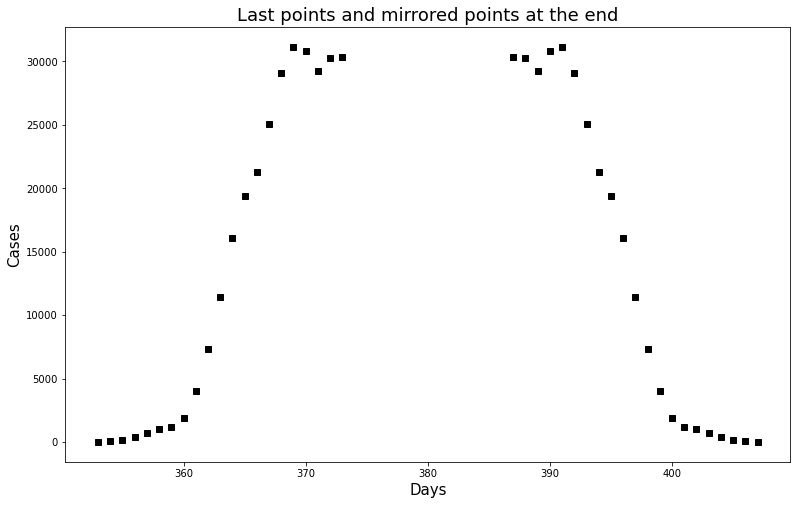

In [36]:
plt.figure(6,figsize=(13,8))
plt.plot(Final['x_fin'],Final['y_fin'],'ks',ms=6)
plt.xlabel("Days",fontsize=15)
plt.ylabel("Cases",fontsize=15)
plt.title("Last points and mirrored points at the end",fontsize=18)

In [40]:
def Gaussian_func(x,x0,a,b):
    return a*np.exp(-((x-x0)/b)**2./2)
def Gaussian_fit(x,y): 
    
    # Initial parameter estimation 
    cent_pred=np.mean(x)
    
    b_pred=(x.max()-x.min())/4. #we assume that the whole x length is 4 stds
    a_pred=y.max()
   
    # Fit
    popt, pcov = curve_fit(Gaussian_func, x,y,p0=[cent_pred,a_pred,b_pred])
    
    # Parameter Output
    print('x0: {0:6.3f} with std= {1:6.3f}'.format(popt[0],pcov[0,0]**0.5))
    print('Amp: {0:6.3f} with std= {1:6.3f}'.format(popt[1],pcov[1,1]**0.5))
    print('sigma: {0:6.3f} with std= {1:6.3f}'.format(popt[2],pcov[2,2]**0.5))
    xx=np.linspace(x.min(),x.max(),100)
    return {'x_fit':xx,'fit':Gaussian_func(xx, *popt),'params':popt,'params_stds':np.diag(pcov)**0.5}

x0: 380.000 with std=  0.301
Amp: 46385.656 with std= 2576.799
sigma: 10.179 with std=  0.402


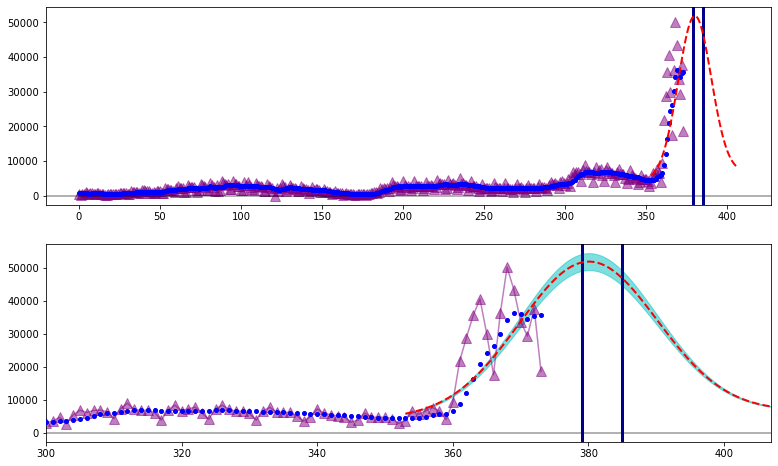

In [45]:
gf=Gaussian_fit(x=Final['x_fin'], y=Final['y_fin'])
def Amp_error(x,params=gf['params'],errs=gf['params_stds']):
    c,a,b=params
    dc,da,db=errs
    return {"err_top":Gaussian_func(x,c,a+da,b),"err_bot":Gaussian_func(x,c,a-da,b)}
Er=Amp_error(x=gf['x_fit'])
day_last=float(Data_Tot.iloc[-1]["date"][-2:])
ID_if=[15-day_last,21-day_last]


plt.figure(6,figsize=(13,8))
plt.subplot(211)
plt.plot(Data_Tot["ID"],Data_Tot["new_cases_smoothed"],'b.',ms=8,zorder=5)
plt.plot(Data_Tot["ID"],Data_Tot["new_cases"],'^',color='purple',ms=10,alpha=0.5)
plt.plot(gf['x_fit'],gf['fit']+bg_line_func(gf['x_fit']),'r--',lw=2,zorder=6)
plt.axhline(0,color='k',alpha=0.4)

for i in ID_if:
    plt.axvline(Data_Tot["ID"].max()+i,color='darkblue',lw=3)
    
plt.subplot(212)
plt.plot(Data_Tot["ID"],Data_Tot["new_cases_smoothed"],'b.',ms=8,zorder=5)
plt.plot(Data_Tot["ID"],Data_Tot["new_cases"],'^-',color='purple',ms=10,alpha=0.5)
plt.plot(gf['x_fit'],gf['fit']+bg_line_func(gf['x_fit']),'r--',lw=2,zorder=6)

plt.fill_between(gf['x_fit'],y1=Er["err_top"]+bg_line_func(gf['x_fit']),y2=Er["err_bot"]+bg_line_func(gf['x_fit']),
                color='c',alpha=0.5)


plt.axhline(0,color='k',alpha=0.4)
plt.xlim(300,gf['x_fit'].max())
for i in ID_if:
    plt.axvline(Data_Tot["ID"].max()+i,color='darkblue',lw=3)

$\Large\underline {Comments}$:

1) The peak seems to have happened already (4-5/01/2022), but we believe that it is too early to claim that, due to the school opening on Monday (10/01/22).

2) Secondly, we also think that the error of $\sim 5.6\%$ (Calculated on Monday 10/01/22) is actually an underestimation. We claimed, that the "peak duration" of the cases follow a peculiar kind of downward rule in order to -indirectly- restrict the amplitude of our fitting function.

3) However, we think that it is an intresting approach of the problem, taking into consideration the dramatic increament of the cases due to Omicron mutation as well as the cases that will appear due to the school opening.
